In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os


In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Data Preprocessing


In [7]:
num_train = train.shape[0]  #store number of train and test examples
num_test = test.shape[0]
y_train = train.SalePrice.values

In [8]:
y_train.shape

(1460,)

In [9]:
trainid = train['Id']
testid = test['Id']
#since each id is unique for a rpw so it makes sense to drop it
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

### Concantenate the train and tests

In [10]:
dataa = pd.concat((train, test)).reset_index(drop = True)


In [11]:
dataa.shape

(2919, 80)

### For the purpose of visualization, we will use Saleprice for some time but later drop it for prediction

In [12]:
dataa['SalePrice'].fillna(dataa['SalePrice'].mean(), inplace=True)


In [13]:
dataa['SalePrice'].isna().sum()

0

In [14]:
dataa.shape

(2919, 80)

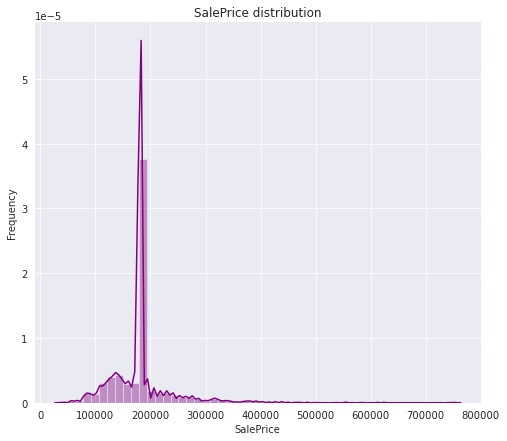

In [15]:
sns.set_style("darkgrid")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(dataa['SalePrice'], color="PURPLE");
ax.xaxis.grid(True)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


In [16]:
print("Skewness: %f" % dataa['SalePrice'].skew())
print("Kurtosis: %f" % dataa['SalePrice'].kurt())


Skewness: 2.660964
Kurtosis: 16.042632


### Now apply log transformation to get a normal distribution

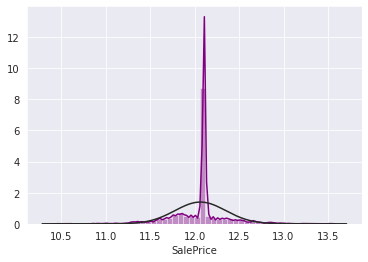

<Figure size 432x288 with 0 Axes>

In [17]:
dataa['SalePrice'] = np.log(dataa['SalePrice'])
sns.distplot(dataa['SalePrice'], fit=norm,  color="PURPLE");
fig = plt.figure()


In [18]:
print("Skewness: %f" % dataa['SalePrice'].skew())
print("Kurtosis: %f" % dataa['SalePrice'].kurt())


Skewness: -0.254842
Kurtosis: 4.329047


## Visualizing the Numeric features by a Scatterplot

In [19]:
#Check the datatypes in the columns
n=[]
for i in train.columns:
    #print((i), type(train[i][0]))
    n.append(type(train[i][0]))
set(n)


{float, numpy.float64, numpy.int64, str}

### Scatterplot of Top Numerical Features

In [20]:
numtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = []
for i in dataa.columns:
    if train[i].dtype in numtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric_features.append(i)  
numeric_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

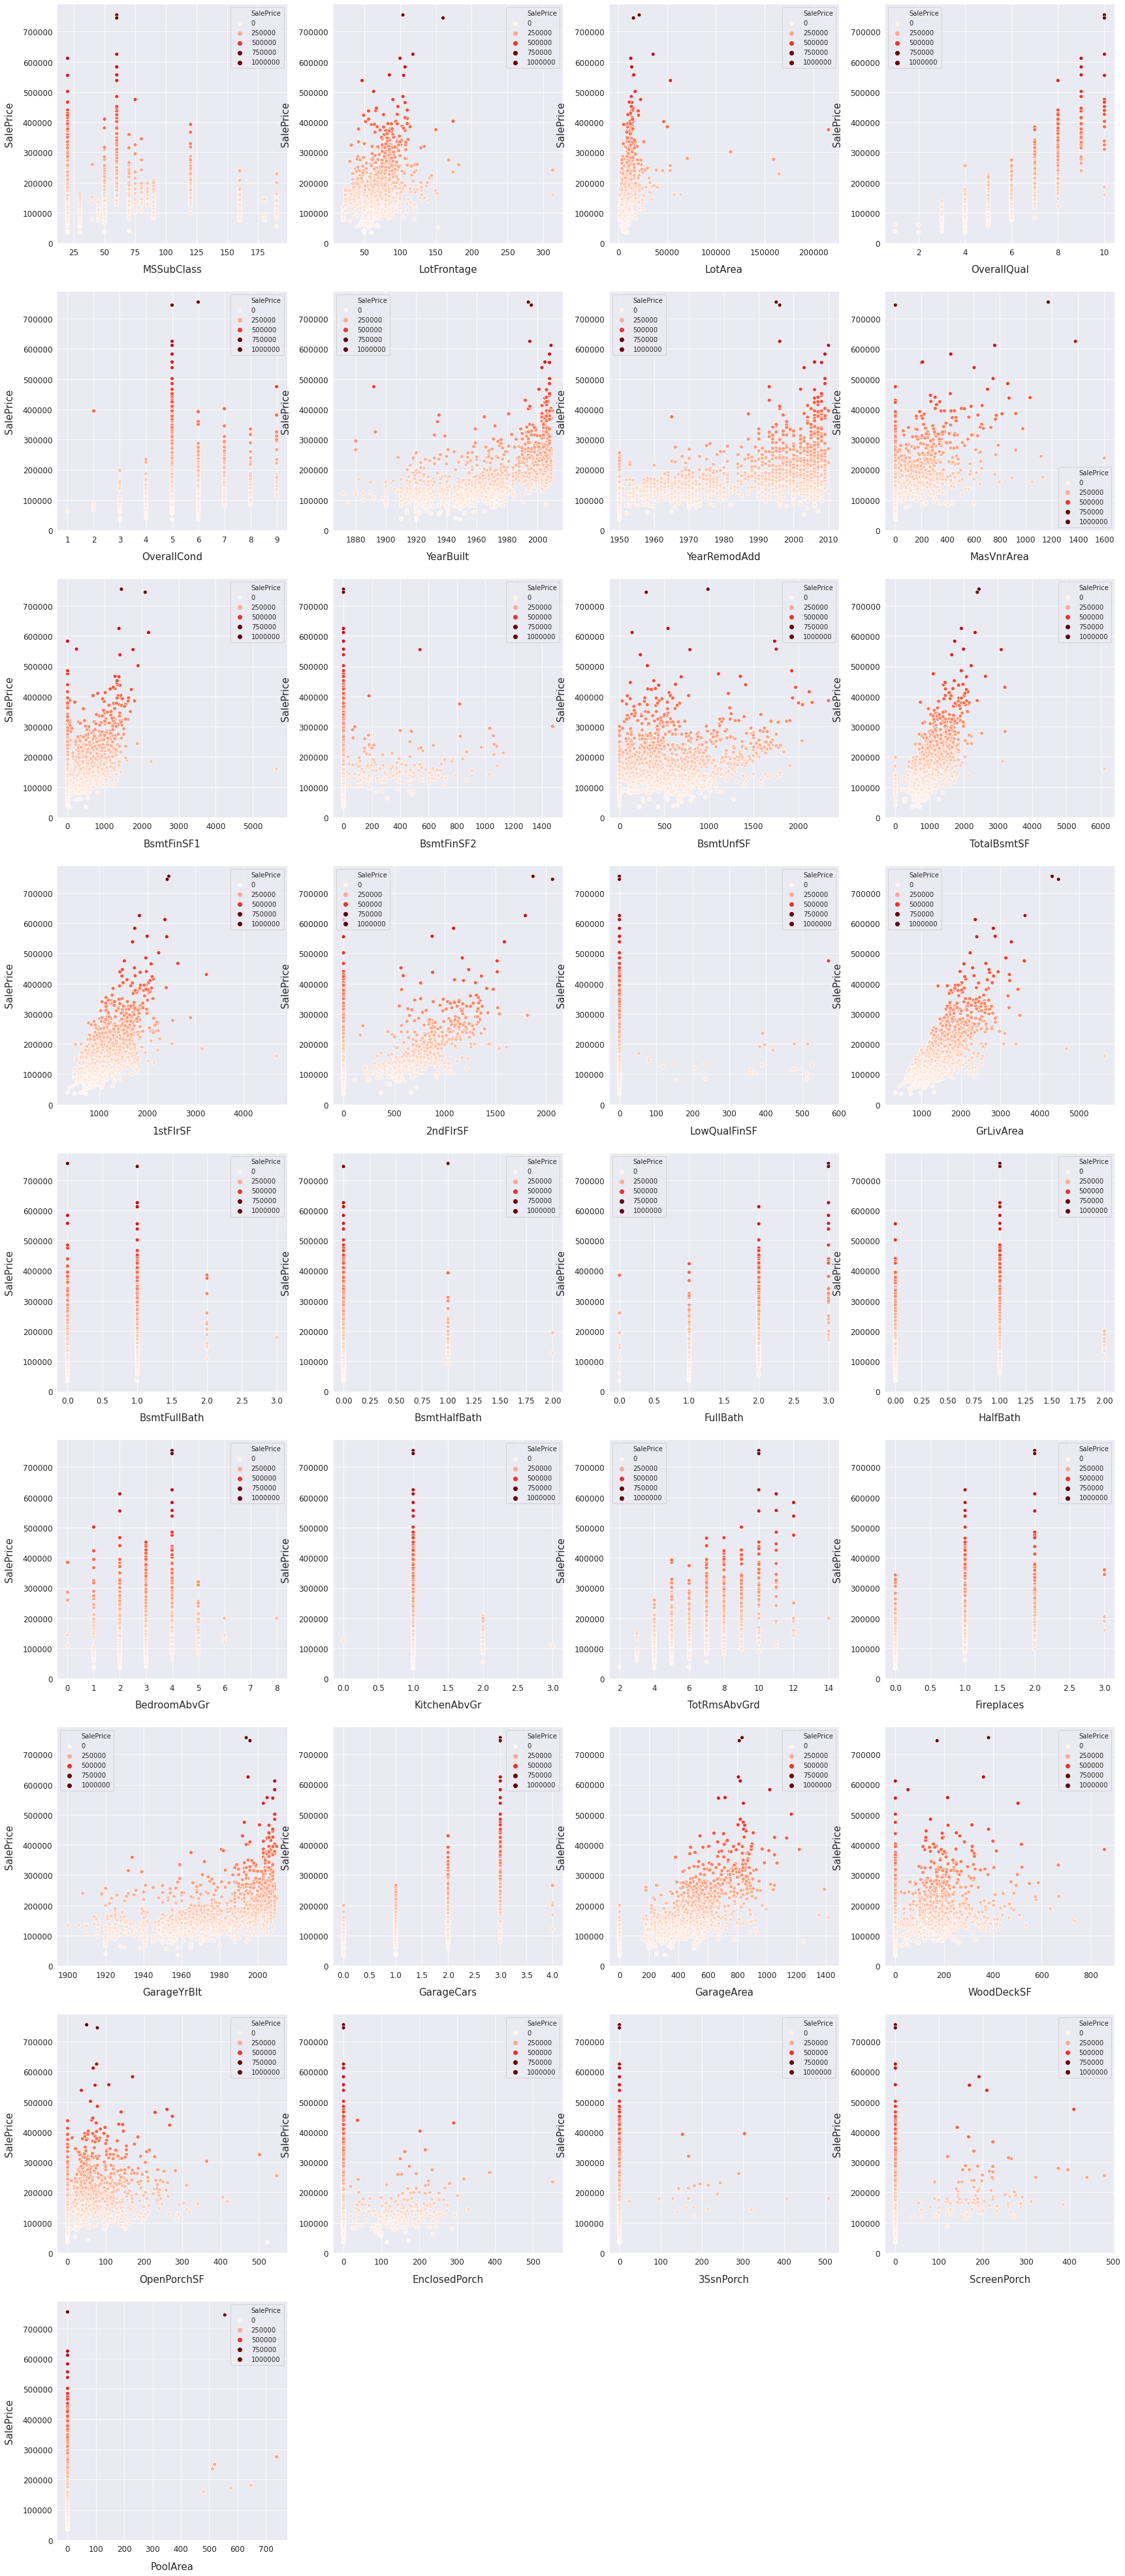

In [21]:
#specify the position of individual graphs
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2) #spacing between subplots
plt.subplots_adjust(top=2)
sns.color_palette("husl", 10)

for i, feature in enumerate(list(dataa[numeric_features]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric_features)), 4, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Reds', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

**Removing skewness of all numerical features**

In [22]:
print(numeric_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [23]:
numeric_feats = dataa.dtypes[dataa.dtypes != "object"].index
print(numeric_feats)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [24]:

skewed_feats = dataa[(numeric_feats)].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        21.947195
PoolArea       16.898328
LotArea        12.822431
LowQualFinSF   12.088761
3SsnPorch      11.376065
KitchenAbvGr    4.302254
BsmtFinSF2      4.145323
EnclosedPorch   4.003891
ScreenPorch     3.946694
BsmtHalfBath    3.929996

In [25]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    dataa[feat] = boxcox1p(dataa[feat], lam)

dataa[skewed_features] = np.log1p(dataa[skewed_features])

There are 37 skewed numerical features to Box Cox transform


# Dealing with missing values

In [26]:
data=dataa.copy()

 Drop the target column

In [27]:
data.drop(['SalePrice'], axis = 1, inplace = True)


In [28]:
def mvalues(tr):
    sns.set_style("white")
    f, ax = plt.subplots(figsize=(8, 7))
    sns.set_color_codes(palette='deep')
    missing = (tr.isnull().sum())
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar(color="r")
    ax.xaxis.grid(False)
    ax.set(ylabel="Number of missing values")
    ax.set(xlabel="Features")
    ax.set(title="Number of missing data")

    

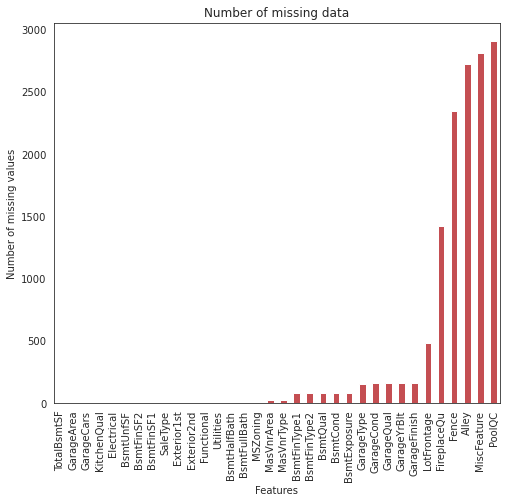

In [29]:
 mvalues(data)

In [30]:
data.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0    1.899792       RL     1.921519  3.006286   Pave   NaN      Reg   
1    1.580793       RL     1.977023  3.030723   Pave   NaN      Reg   
2    1.899792       RL     1.933684  3.060922   Pave   NaN      IR1   
3    1.941469       RL     1.899792  3.029726   Pave   NaN      IR1   
4    1.899792       RL     1.989891  3.105714   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story     1.235549     1.116990   2.720474   
1       Norm     1Fam     1Story     1.181627     1.281654   2.717680   
2       Norm     1Fam     2Story     1.235549     1.116990   2.720269   
3       Norm     1Fam     2Story     1.235549     1.116990   2.711214   
4       Norm     1Fam     2Story     1.281654     1.116990   2.720166   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0      2.720474     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1      2.717680     Gable  CompShg     MetalSd     MetalSd       None   
2      2.720372     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3      2.717053     Gable  CompShg     Wd Sdng     Wd Shng       None   
4      2.720166     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0    2.203773        Gd        TA      PConc       Gd       TA           No   
1    0.000000        TA        TA     CBlock       Gd       TA           Gd   
2    2.157159        Gd        TA      PConc       Gd       TA           Mn   
3    0.000000        TA        TA     BrkTil       TA       Gd           No   
4    2.341020        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ    2.499001          Unf         0.0   2.138099     2.541021   
1          ALQ    2.569771          Unf         0.0   2.292317     2.624109   
2          GLQ    2.415944          Unf         0.0   2.390327     2.556610   
3          ALQ    2.227243          Unf         0.0   2.439604     2.513988   
4          GLQ    2.482498          Unf         0.0   2.417792     2.603474   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr  2.541021  2.540514           0.0   
1    GasA        Ex          Y      SBrkr  2.624109  0.000000           0.0   
2    GasA        Ex          Y      SBrkr  2.556610  2.543537           0.0   
3    GasA        Gd          Y      SBrkr  2.566001  2.513988           0.0   
4    GasA        Ex          Y      SBrkr  2.603474  2.585609           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   2.687772      0.548389      0.000000  0.785871  0.548389      0.932543   
1   2.624109      0.000000      0.548389  0.785871  0.000000      0.932543   
2   2.696793      0.548389      0.000000  0.785871  0.548389      0.932543   
3   2.688620      0.548389      0.000000  0.548389  0.000000      0.932543   
4   2.739551      0.548389      0.000000  0.785871  0.548389      1.036855   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0      0.548389          Gd      1.281654        Typ    0.000000         NaN   
1      0.548389          TA      1.181627        Typ    0.548389          TA   
2      0.548389          Gd      1.181627        Typ    0.548389          TA   
3      0.548389          Gd      1.235549        Typ    0

**Dropping highest missing data columns**

data.drop(columns=['PoolQC', 'MiscFeature', 'Fence', 'Alley' ], inplace=True)

### Now all the missing values will be handled according to their type

In [31]:
#train["PoolQC"] = train["PoolQC"].fillna("None")

#train["MiscFeature"] = train["MiscFeature"].fillna("None")

#train["Alley"] = train["Alley"].fillna("None")

#train["Fence"] = train["Fence"].fillna("None")

data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

data = data.drop(['Utilities'], axis=1)

data["Functional"] = data["Functional"].fillna("Typ")

data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

data['MSSubClass'] = data['MSSubClass'].fillna("None")

**Checking for null values**

In [32]:
data['MiscFeature']=data['MiscFeature'].fillna("None")

In [33]:
sum(data.isna().sum())

7978

**Transform some variables into their correct type**

In [34]:

data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)

data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

LABEL ENCODE Reference : https://2-chae.github.io/category/1.ai/30

In [35]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(dataa[c].values)) 
    dataa[c] = lbl.transform(list(dataa[c].values))

# shape        
print('Shape all_data: {}'.format(dataa.shape))

Shape all_data: (2919, 80)


### Plot Correlation Matrix 

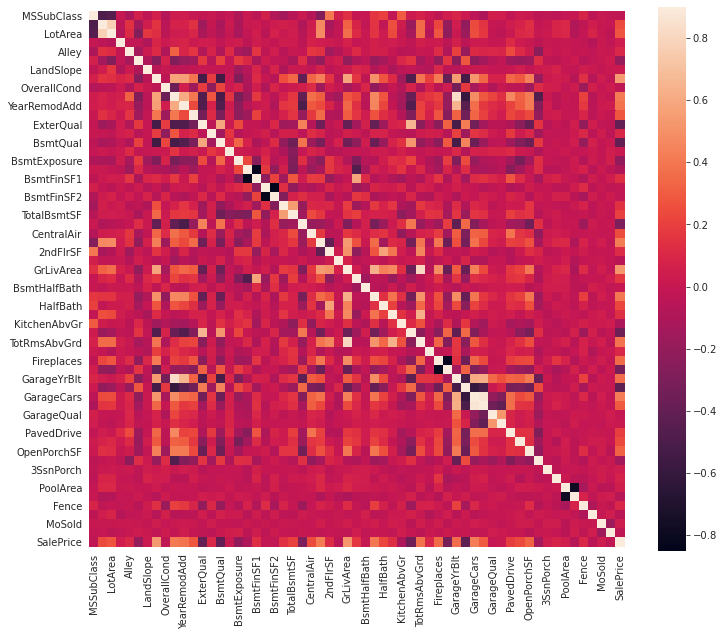

In [36]:
cor=dataa.corr()
plt.subplots(figsize=(12,10))
sns.heatmap(cor, vmax=0.9,  square=True)

Top correlated features from the heatmap are: YearBuilt, TotalBsmtSF, 1stFlrSF, YearBuilt, and Garage Variables.
Now calculate correlation with SalesPrice

#### Top 10 Highly Correlated Features with SalesPrice

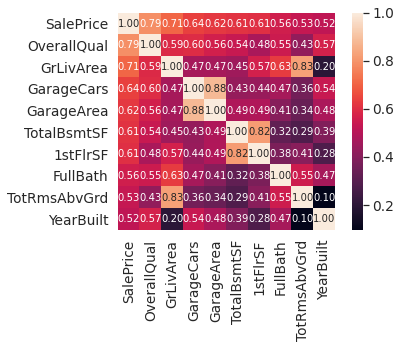

In [37]:
cor=train.corr()
cols = cor.nlargest(10, 'SalePrice')['SalePrice'].index
sp = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(sp, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Pairplots of SalesPrice with Highly Correlated Features


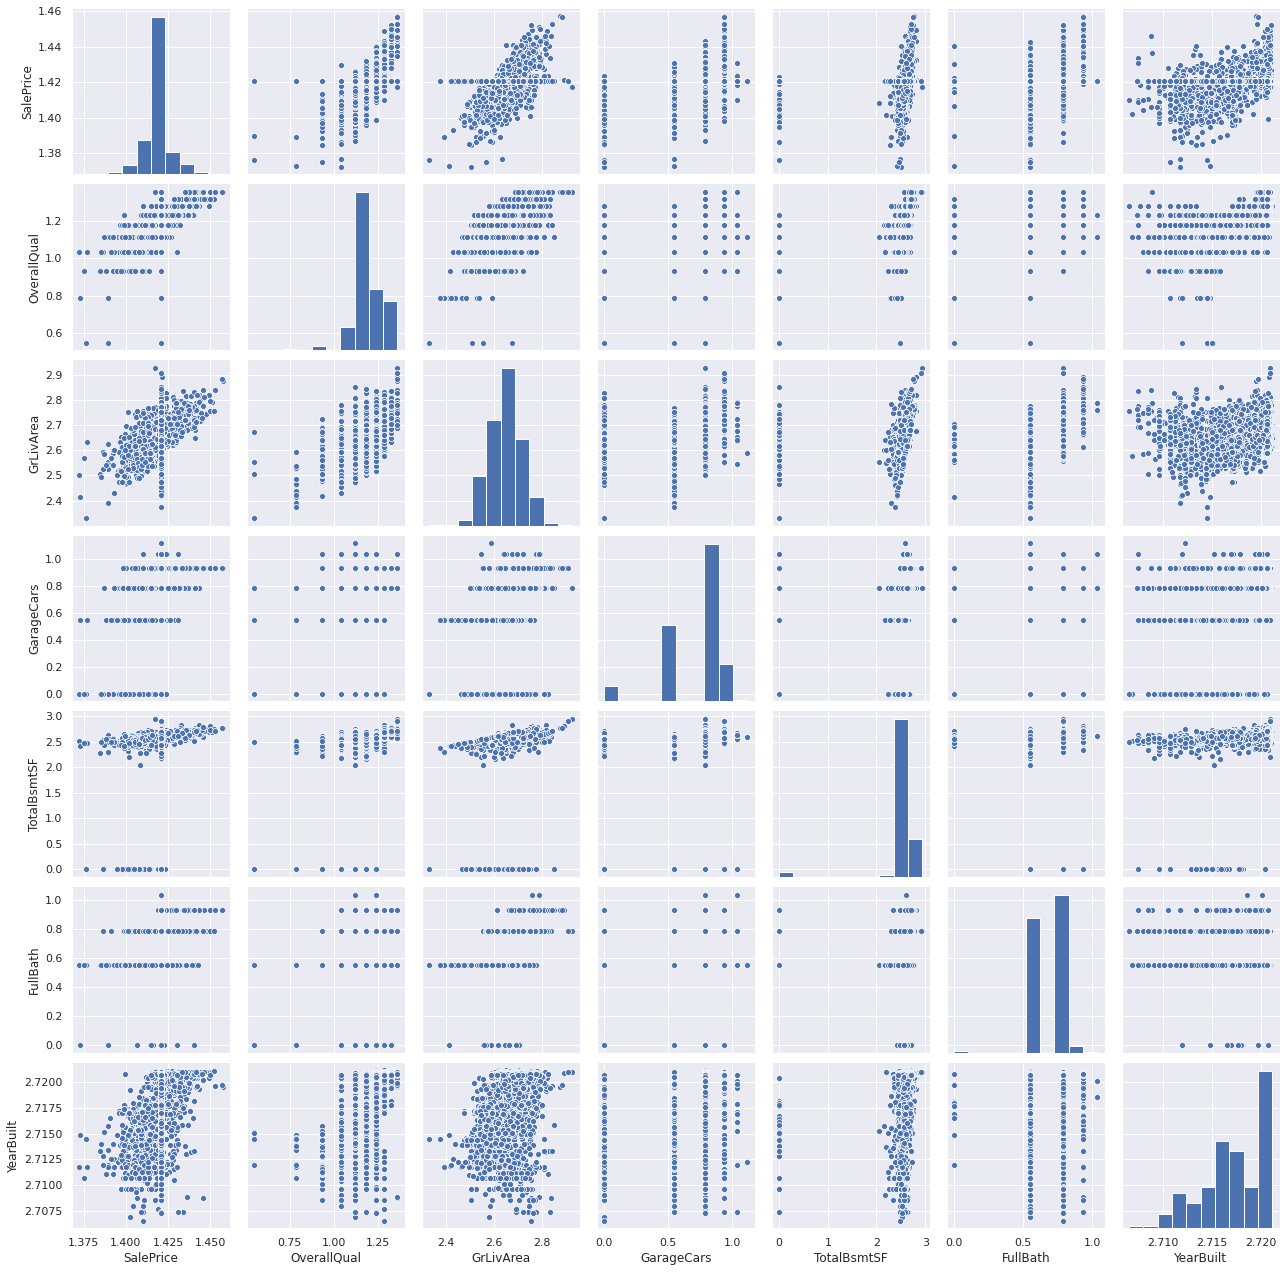

In [38]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(dataa[cols], size = 2.5)
plt.show();

#Since ID is unique for each row so we drop it
data=data.drop(columns=['Id'])

In [39]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'O

**Encode the Category Variables**

In [40]:
data.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  1.8997924093002385       RL     1.921519  3.006286   Pave   NaN      Reg   
1   1.580792865271824       RL     1.977023  3.030723   Pave   NaN      Reg   
2  1.8997924093002385       RL     1.933684  3.060922   Pave   NaN      IR1   
3   1.941468956599639       RL     1.899792  3.029726   Pave   NaN      IR1   
4  1.8997924093002385       RL     1.989891  3.105714   Pave   NaN      IR1   

  LandContour LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1         Lvl       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3         Lvl    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4         Lvl       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual         OverallCond  YearBuilt  YearRemodAdd  \
0     2Story     1.235549  1.1169895666684995   2.720474      2.720474   
1     1Story     1.181627  1.2816542716629817   2.717680      2.717680   
2     2Story     1.235549  1.1169895666684995   2.720269      2.720372   
3     2Story     1.235549  1.1169895666684995   2.711214      2.717053   
4     2Story     1.281654  1.1169895666684995   2.720166      2.720166   

  RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.203773        Gd   
1     Gable  CompShg     MetalSd     MetalSd       None    0.000000        TA   
2     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.157159        Gd   
3     Gable  CompShg     Wd Sdng     Wd Shng       None    0.000000        TA   
4     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.341020        Gd   

  ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        TA      PConc       Gd       TA           No          GLQ   
1        TA     CBlock       Gd       TA           Gd          ALQ   
2        TA      PConc       Gd       TA           Mn          GLQ   
3        TA     BrkTil       TA       Gd           No          ALQ   
4        TA      PConc       Gd       TA           Av          GLQ   

   BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0    2.499001          Unf         0.0   2.138099     2.541021    GasA   
1    2.569771          Unf         0.0   2.292317     2.624109    GasA   
2    2.415944          Unf         0.0   2.390327     2.556610    GasA   
3    2.227243          Unf         0.0   2.439604     2.513988    GasA   
4    2.482498          Unf         0.0   2.417792     2.603474    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr  2.541021  2.540514           0.0   
1        Ex          Y      SBrkr  2.624109  0.000000           0.0   
2        Ex          Y      SBrkr  2.556610  2.543537           0.0   
3        Gd          Y      SBrkr  2.566001  2.513988           0.0   
4        Ex          Y      SBrkr  2.603474  2.585609           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   2.687772      0.548389      0.000000  0.785871  0.548389      0.932543   
1   2.624109      0.000000      0.548389  0.785871  0.000000      0.932543   
2   2.696793      0.548389      0.000000  0.785871  0.548389      0.932543   
3   2.688620      0.548389      0.000000  0.548389  0.000000      0.932543   
4   2.739551      0.548389      0.000000  0.785871  0.548389      1.036855   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0      0.548389          Gd      1.281654        Typ    0.000000        None   
1      0.548389          TA      1.181627        Typ    0.548389          TA   
2      0.548389          Gd      1.181627        Typ    0.548389          TA   
3      0.548389          Gd      1.

In [41]:
category=[]
c= 'str'
for i in train.columns:
    a=train[i][0]
    if type(a) == type(c):
        category.append(i)


In [42]:
print(category)  


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


**Creating New Features**

In [43]:
data['Total_Bathrooms'] = (data['FullBath'] + (data['HalfBath']) +
                               data['BsmtFullBath'] + (data['BsmtHalfBath']))

In [44]:
# Adding total square footage feature 
data['TotalSqFootage'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [45]:
sum(data.isna().sum())

7978

In [46]:
data.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  1.8997924093002385       RL     1.921519  3.006286   Pave   NaN      Reg   
1   1.580792865271824       RL     1.977023  3.030723   Pave   NaN      Reg   
2  1.8997924093002385       RL     1.933684  3.060922   Pave   NaN      IR1   
3   1.941468956599639       RL     1.899792  3.029726   Pave   NaN      IR1   
4  1.8997924093002385       RL     1.989891  3.105714   Pave   NaN      IR1   

  LandContour LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1         Lvl       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3         Lvl    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4         Lvl       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual         OverallCond  YearBuilt  YearRemodAdd  \
0     2Story     1.235549  1.1169895666684995   2.720474      2.720474   
1     1Story     1.181627  1.2816542716629817   2.717680      2.717680   
2     2Story     1.235549  1.1169895666684995   2.720269      2.720372   
3     2Story     1.235549  1.1169895666684995   2.711214      2.717053   
4     2Story     1.281654  1.1169895666684995   2.720166      2.720166   

  RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.203773        Gd   
1     Gable  CompShg     MetalSd     MetalSd       None    0.000000        TA   
2     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.157159        Gd   
3     Gable  CompShg     Wd Sdng     Wd Shng       None    0.000000        TA   
4     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.341020        Gd   

  ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        TA      PConc       Gd       TA           No          GLQ   
1        TA     CBlock       Gd       TA           Gd          ALQ   
2        TA      PConc       Gd       TA           Mn          GLQ   
3        TA     BrkTil       TA       Gd           No          ALQ   
4        TA      PConc       Gd       TA           Av          GLQ   

   BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0    2.499001          Unf         0.0   2.138099     2.541021    GasA   
1    2.569771          Unf         0.0   2.292317     2.624109    GasA   
2    2.415944          Unf         0.0   2.390327     2.556610    GasA   
3    2.227243          Unf         0.0   2.439604     2.513988    GasA   
4    2.482498          Unf         0.0   2.417792     2.603474    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr  2.541021  2.540514           0.0   
1        Ex          Y      SBrkr  2.624109  0.000000           0.0   
2        Ex          Y      SBrkr  2.556610  2.543537           0.0   
3        Gd          Y      SBrkr  2.566001  2.513988           0.0   
4        Ex          Y      SBrkr  2.603474  2.585609           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   2.687772      0.548389      0.000000  0.785871  0.548389      0.932543   
1   2.624109      0.000000      0.548389  0.785871  0.000000      0.932543   
2   2.696793      0.548389      0.000000  0.785871  0.548389      0.932543   
3   2.688620      0.548389      0.000000  0.548389  0.000000      0.932543   
4   2.739551      0.548389      0.000000  0.785871  0.548389      1.036855   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0      0.548389          Gd      1.281654        Typ    0.000000        None   
1      0.548389          TA      1.181627        Typ    0.548389          TA   
2      0.548389          Gd      1.181627        Typ    0.548389          TA   
3      0.548389          Gd      1.

In [47]:
dt=data.copy()

In [48]:
dt.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  1.8997924093002385       RL     1.921519  3.006286   Pave   NaN      Reg   
1   1.580792865271824       RL     1.977023  3.030723   Pave   NaN      Reg   
2  1.8997924093002385       RL     1.933684  3.060922   Pave   NaN      IR1   
3   1.941468956599639       RL     1.899792  3.029726   Pave   NaN      IR1   
4  1.8997924093002385       RL     1.989891  3.105714   Pave   NaN      IR1   

  LandContour LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1         Lvl       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2         Lvl    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3         Lvl    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4         Lvl       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual         OverallCond  YearBuilt  YearRemodAdd  \
0     2Story     1.235549  1.1169895666684995   2.720474      2.720474   
1     1Story     1.181627  1.2816542716629817   2.717680      2.717680   
2     2Story     1.235549  1.1169895666684995   2.720269      2.720372   
3     2Story     1.235549  1.1169895666684995   2.711214      2.717053   
4     2Story     1.281654  1.1169895666684995   2.720166      2.720166   

  RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual  \
0     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.203773        Gd   
1     Gable  CompShg     MetalSd     MetalSd       None    0.000000        TA   
2     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.157159        Gd   
3     Gable  CompShg     Wd Sdng     Wd Shng       None    0.000000        TA   
4     Gable  CompShg     VinylSd     VinylSd    BrkFace    2.341020        Gd   

  ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        TA      PConc       Gd       TA           No          GLQ   
1        TA     CBlock       Gd       TA           Gd          ALQ   
2        TA      PConc       Gd       TA           Mn          GLQ   
3        TA     BrkTil       TA       Gd           No          ALQ   
4        TA      PConc       Gd       TA           Av          GLQ   

   BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0    2.499001          Unf         0.0   2.138099     2.541021    GasA   
1    2.569771          Unf         0.0   2.292317     2.624109    GasA   
2    2.415944          Unf         0.0   2.390327     2.556610    GasA   
3    2.227243          Unf         0.0   2.439604     2.513988    GasA   
4    2.482498          Unf         0.0   2.417792     2.603474    GasA   

  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0        Ex          Y      SBrkr  2.541021  2.540514           0.0   
1        Ex          Y      SBrkr  2.624109  0.000000           0.0   
2        Ex          Y      SBrkr  2.556610  2.543537           0.0   
3        Gd          Y      SBrkr  2.566001  2.513988           0.0   
4        Ex          Y      SBrkr  2.603474  2.585609           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   2.687772      0.548389      0.000000  0.785871  0.548389      0.932543   
1   2.624109      0.000000      0.548389  0.785871  0.000000      0.932543   
2   2.696793      0.548389      0.000000  0.785871  0.548389      0.932543   
3   2.688620      0.548389      0.000000  0.548389  0.000000      0.932543   
4   2.739551      0.548389      0.000000  0.785871  0.548389      1.036855   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0      0.548389          Gd      1.281654        Typ    0.000000        None   
1      0.548389          TA      1.181627        Typ    0.548389          TA   
2      0.548389          Gd      1.181627        Typ    0.548389          TA   
3      0.548389          Gd      1.

In [49]:
dt = pd.get_dummies(dt) #.reset_index(drop=True)
dt.shape

(2919, 337)

In [50]:
dt.head()

LotFrontage   LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0     1.921519  3.006286     1.235549   2.720474      2.720474    2.203773   
1     1.977023  3.030723     1.181627   2.717680      2.717680    0.000000   
2     1.933684  3.060922     1.235549   2.720269      2.720372    2.157159   
3     1.899792  3.029726     1.235549   2.711214      2.717053    0.000000   
4     1.989891  3.105714     1.281654   2.720166      2.720166    2.341020   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
0    2.499001         0.0   2.138099     2.541021  2.541021  2.540514   
1    2.569771         0.0   2.292317     2.624109  2.624109  0.000000   
2    2.415944         0.0   2.390327     2.556610  2.556610  2.543537   
3    2.227243         0.0   2.439604     2.513988  2.566001  2.513988   
4    2.482498         0.0   2.417792     2.603474  2.603474  2.585609   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0           0.0   2.687772      0.548389      0.000000  0.785871  0.548389   
1           0.0   2.624109      0.000000      0.548389  0.785871  0.000000   
2           0.0   2.696793      0.548389      0.000000  0.785871  0.548389   
3           0.0   2.688620      0.548389      0.000000  0.548389  0.000000   
4           0.0   2.739551      0.548389      0.000000  0.785871  0.548389   

   BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  \
0      0.932543      0.548389      1.281654    0.000000     2.720474   
1      0.932543      0.548389      1.181627    0.548389     2.717680   
2      0.932543      0.548389      1.181627    0.548389     2.720269   
3      0.932543      0.548389      1.235549    0.548389     2.719960   
4      1.036855      0.548389      1.321823    0.548389     2.720166   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0    0.785871    2.442892    0.000000     1.904295       0.000000        0.0   
1    0.785871    2.403525    2.303605     0.000000       0.000000        0.0   
2    0.785871    2.466024    0.000000     1.800615       0.000000        0.0   
3    0.932543    2.478071    0.000000     1.748353       2.282151        0.0   
4    0.932543    2.535893    2.198766     1.989891       0.000000        0.0   

   ScreenPorch  PoolArea  MiscVal  Total_Bathrooms  TotalSqFootage  \
0          0.0       0.0      0.0         1.882649        7.622556   
1          0.0       0.0      0.0         1.334260        5.248217   
2          0.0       0.0      0.0         1.882649        7.656757   
3          0.0       0.0      0.0         1.096778        7.593976   
4          0.0       0.0      0.0         1.882649        7.792556   

   MSSubClass_1.580792865271824  MSSubClass_1.7032957185852295  \
0                             0                              0   
1                             1                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   

   MSSubClass_1.7867367183827292  MSSubClass_1.820109600983434  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   MSSubClass_1.849588532587341  MSSubClass_1.8997924093002385  \
0                             0                              1   
1                             0                              0   
2                             0                              1   
3                             0                              0   
4                             0                              1   

   MSSubClass_1.941468956599639  MSSubClass_1.959901258980303  \
0                             0    

In [51]:
(dt.isna().sum())

LotFrontage                       0
LotArea                           0
OverallQual                       0
YearBuilt                         0
YearRemodAdd                      0
MasVnrArea                        0
BsmtFinSF1                        0
BsmtFinSF2                        0
BsmtUnfSF                         0
TotalBsmtSF                       0
1stFlrSF                          0
2ndFlrSF                          0
LowQualFinSF                      0
GrLivArea                         0
BsmtFullBath                      0
BsmtHalfBath                      0
FullBath                          0
HalfBath                          0
BedroomAbvGr                      0
KitchenAbvGr                      0
TotRmsAbvGrd                      0
Fireplaces                        0
GarageYrBlt                       0
GarageCars                        0
GarageArea                        0
WoodDeckSF                        0
OpenPorchSF                       0
EnclosedPorch               

Baseline Model

Reference: 
1.  pipeline : https://rk1993.tistory.com/entry/Python-sklearnpipeline-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline%EC%9D%B4%EB%9E%80
sklearn.base : https://suuntree.tistory.com/307

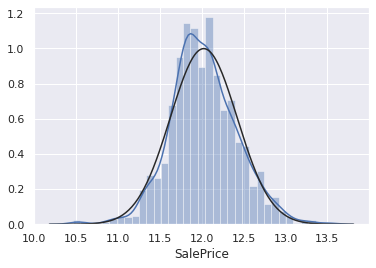

In [52]:
trainn = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
trainn["SalePrice"] = np.log1p(trainn["SalePrice"])
#Check the new distribution 
sns.distplot(trainn['SalePrice'] , fit=norm);
y_train = trainn.SalePrice.values

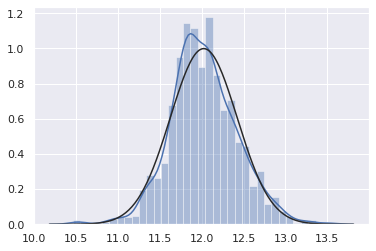

In [53]:
sns.distplot(y_train , fit=norm);

In [54]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [55]:
train = dt[:num_train] #here num_train is the number of columns of training data
test = dt[num_train:]

In [56]:
train.head()

LotFrontage   LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0     1.921519  3.006286     1.235549   2.720474      2.720474    2.203773   
1     1.977023  3.030723     1.181627   2.717680      2.717680    0.000000   
2     1.933684  3.060922     1.235549   2.720269      2.720372    2.157159   
3     1.899792  3.029726     1.235549   2.711214      2.717053    0.000000   
4     1.989891  3.105714     1.281654   2.720166      2.720166    2.341020   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
0    2.499001         0.0   2.138099     2.541021  2.541021  2.540514   
1    2.569771         0.0   2.292317     2.624109  2.624109  0.000000   
2    2.415944         0.0   2.390327     2.556610  2.556610  2.543537   
3    2.227243         0.0   2.439604     2.513988  2.566001  2.513988   
4    2.482498         0.0   2.417792     2.603474  2.603474  2.585609   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0           0.0   2.687772      0.548389      0.000000  0.785871  0.548389   
1           0.0   2.624109      0.000000      0.548389  0.785871  0.000000   
2           0.0   2.696793      0.548389      0.000000  0.785871  0.548389   
3           0.0   2.688620      0.548389      0.000000  0.548389  0.000000   
4           0.0   2.739551      0.548389      0.000000  0.785871  0.548389   

   BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  \
0      0.932543      0.548389      1.281654    0.000000     2.720474   
1      0.932543      0.548389      1.181627    0.548389     2.717680   
2      0.932543      0.548389      1.181627    0.548389     2.720269   
3      0.932543      0.548389      1.235549    0.548389     2.719960   
4      1.036855      0.548389      1.321823    0.548389     2.720166   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0    0.785871    2.442892    0.000000     1.904295       0.000000        0.0   
1    0.785871    2.403525    2.303605     0.000000       0.000000        0.0   
2    0.785871    2.466024    0.000000     1.800615       0.000000        0.0   
3    0.932543    2.478071    0.000000     1.748353       2.282151        0.0   
4    0.932543    2.535893    2.198766     1.989891       0.000000        0.0   

   ScreenPorch  PoolArea  MiscVal  Total_Bathrooms  TotalSqFootage  \
0          0.0       0.0      0.0         1.882649        7.622556   
1          0.0       0.0      0.0         1.334260        5.248217   
2          0.0       0.0      0.0         1.882649        7.656757   
3          0.0       0.0      0.0         1.096778        7.593976   
4          0.0       0.0      0.0         1.882649        7.792556   

   MSSubClass_1.580792865271824  MSSubClass_1.7032957185852295  \
0                             0                              0   
1                             1                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   

   MSSubClass_1.7867367183827292  MSSubClass_1.820109600983434  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   MSSubClass_1.849588532587341  MSSubClass_1.8997924093002385  \
0                             0                              1   
1                             0                              0   
2                             0                              1   
3                             0                              0   
4                             0                              1   

   MSSubClass_1.941468956599639  MSSubClass_1.959901258980303  \
0                             0    

In [57]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [58]:
#Define cross validation strategy
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [59]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Lasso score: 0.1240 (0.0146)



In [60]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


ElasticNet score: 0.1241 (0.0146)

Kernel Ridge score: 0.1485 (0.0105)

Gradient Boosting score: 0.1249 (0.0132)

[16:27:55] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:23] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not

**Stacking models** Ref: https://zhuanlan.zhihu.com/p/67711746

**Stacking models**

**Simplest Stacking approach : Averaging base models**

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

**Averaged base models class**

In [61]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

Averaged base models score

We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more models in the mix.

In [62]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1223 (0.0131)



**Less simple Stacking : Adding a Meta-model
**
In this approach, we add a meta-model(model6) on averaged base models(model1-model5) and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

1. Split the total training set into two disjoint sets (here train and .holdout )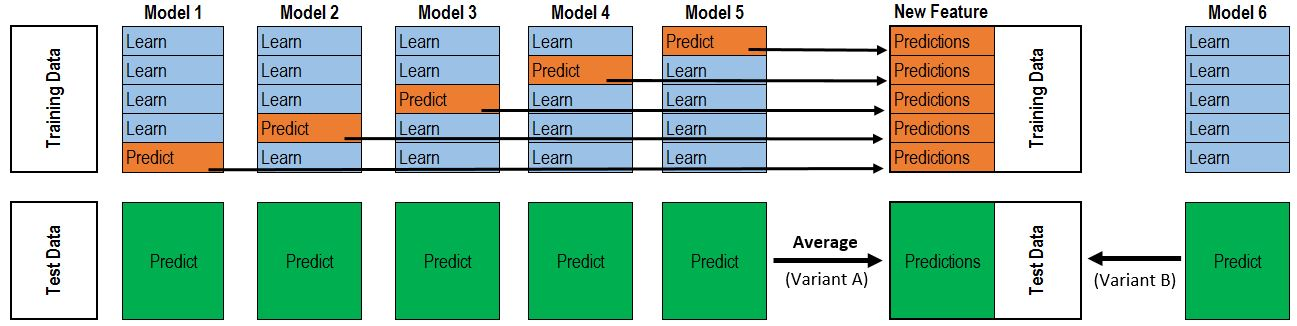

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.


Ref: https://zhuanlan.zhihu.com/p/67711746

**Stacking averaged Models Class**

In [63]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking Averaged models Score

To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [64]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1197 (0.0139)


Ensembling StackedRegressor, XGBoost and LightGBM
We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [65]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Final Training and Prediction

In [66]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08558971873117359


In [67]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[16:34:53] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.0804454526217297


In [68]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07629449346806247


In [69]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.08079840369238624


In [70]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [71]:
sub = pd.DataFrame()
sub['Id'] = testid
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)